Format data in Vowpal Wabbit form
===


In [23]:
import os
import re
import pandas as pd
import numpy as np
import sklearn
from collections import Counter
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
import random

In [2]:
annotation_data_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/export"
assert os.path.exists(annotation_data_dir)

vw_working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/journey_phases/vw"
os.makedirs(vw_working_dir, exist_ok=True)

In [3]:
phase_annotation_filename = "journal_journey_phase_annotations.csv"
df = pd.read_csv(os.path.join(annotation_data_dir, phase_annotation_filename))
df.head()

,site_id,journal_oid,annotator_usernames,conflict_status,data
0,818475,51fc73ecac7ee9320f784277,luoxx498,SINGLE USER,treatment
1,818475,5205b4ab4db921e73f48120f,luoxx498,SINGLE USER,treatment
2,818475,52101f98cb16b414771974c9,luoxx498,SINGLE USER,treatment
3,818475,521342a20dad1097034d2c4c,luoxx498,SINGLE USER,treatment
4,818475,522b5c8fa589b46a0bd42872,luoxx498,SINGLE USER,treatment


In [4]:
Counter(df['conflict_status']).most_common()

[('SINGLE USER', 571),
 ('NO CONFLICT', 134),
 ('RESOLVED', 91),
 ('AMBIGUOUS', 12)]

In [5]:
Counter(df['data']).most_common()

[('treatment', 564),
 ('info_seeking', 77),
 ('cured', 43),
 ('unknown', 41),
 ('treatment|unknown', 18),
 ('treatment|cured', 18),
 ('info_seeking|unknown', 8),
 ('screening|info_seeking', 6),
 ('info_seeking;info_seeking|unknown', 5),
 ('info_seeking|treatment', 5),
 ('cured|unknown', 5),
 ('treatment;treatment|unknown', 3),
 ('treatment|unknown;treatment', 3),
 ('screening', 3),
 ('end_of_life', 3),
 ('screening|info_seeking|unknown', 1),
 ('cured|unknown;cured', 1),
 ('treatment|end_of_life', 1),
 ('screening|treatment', 1),
 ('treatment|cured|unknown', 1),
 ('info_seeking|cured', 1)]

In [6]:
full = pd.read_csv(os.path.join(annotation_data_dir, "annotation_data_complete.csv"))
Counter(full['annotation_type']).most_common()

[('journal_journey_phase', 1045),
 ('journal_author_type', 874),
 ('journal_note', 52),
 ('journal_patient_responsibilities', 41)]

In [7]:
print("Site Id\tNum Annotated Journals")
print("---------")
for key, group in df.groupby(by=("site_id",)):
    print(key, len(group))

Site Id	Num Annotated Journals
---------
818475 16
820192 20
826591 13
829111 42
839971 11
845819 19
846593 23
847311 27
851522 40
855625 29
857627 35
863706 49
864283 20
866641 19
867125 20
867427 35
882253 44
888277 16
900129 25
911545 28
912454 21
912713 11
923316 21
966641 39
987982 16
1006567 16
1010066 17
1015767 27
1022397 22
1023926 29
1024634 18
1026937 15
1028140 25


In [8]:
# from the author_type annotations, construct a dictionary indicating which journals have an author id other than "patient"
author_types = full[full['annotation_type'] == 'journal_author_type']
bad_author_dict = {}
for key, group in author_types.groupby(('site_id', 'journal_oid')):
    author_types = set(group['data'])
    is_bad_author = 'cg' in author_types or 'pcg' in author_types or 'unk' in author_types
    bad_author_dict[key] = is_bad_author

In [9]:
# identify the indices of rows that should be used in the training/holdout data
correct_rows = 0
bad_author_journals_skipped = 0
ambiguous_phase_journals_skipped = 0

index_list = []
for i in range(len(df)):
    row = df.iloc[i]
    key = (row['site_id'], row['journal_oid'])
    if key in bad_author_dict and bad_author_dict[key]:
        bad_author_journals_skipped += 1
        continue
    if row['conflict_status'] == "AMBIGUOUS":
        ambiguous_phase_journals_skipped += 1
        continue
    # write this
    correct_rows += 1
    index_list.append(row.name)
    
# TODO Only include site_ids for sites that have at least 50% of their journals tagged.

correct_rows, bad_author_journals_skipped, ambiguous_phase_journals_skipped

(660, 136, 12)

In [10]:
# get the dataframe containing only the rows that will actually be used in our data
valid_df = df.loc[index_list]
assert len(valid_df) == correct_rows

In [11]:
# identify sites that will be used in the training set vs the holdout set
grouped = valid_df.groupby(by="site_id")
site_ids = list(grouped.groups.keys())
random.shuffle(site_ids)

holdout_percent = 0.2
holdout_start_index = len(site_ids) - int(len(site_ids) * holdout_percent)

train_site_ids = site_ids[:holdout_start_index]
valid_site_ids = site_ids[holdout_start_index:]
len(train_site_ids), len(valid_site_ids)

(26, 6)

In [12]:
# format the data rows into Vowpal Wabbit format
all_phases = ['screening', 'info_seeking', 'treatment', 'cured', 'end_of_life']

train_lines = []
valid_lines = []

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html_text):
    s = MLStripper()
    s.feed(html_text)
    return s.get_data()


def get_cleaned_text_from_token_list(token_list):
    cleaned_text = " ".join(token_list).replace(':', 'COLON').replace('|', 'PIPE').replace("\n", "NEWLINE ")
    return cleaned_text

def get_cleaned_text(text):
    stripped = strip_tags(text)
    tokens = word_tokenize(stripped)
    tokens = [token.lower() for token in tokens]
    cleaned_text = get_cleaned_text_from_token_list(tokens)
    return cleaned_text

def get_db():
    journal_wd="/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/extract_site_features"
    db_filename = os.path.join(journal_wd, "journal_text.db")
    db = sqlite3.connect(
            db_filename,
            detect_types=sqlite3.PARSE_DECLTYPES
        )
    db.row_factory = sqlite3.Row
    return db

#https://github.com/JohnLangford/vowpal_wabbit/wiki/Cost-Sensitive-One-Against-All-(csoaa)-multi-class-example
# Note that labels with lower costs are preferred
def get_vw_format(site_id, journal_oid, phases):
    site_id = int(site_id)
    
    unknown = False
    if "unknown" in phases:
        phases.remove("unknown")
        unknown = True
    label_section = ""
    for phase in all_phases:
        if phase in phases:
            cost = 0
            if unknown:
                cost = 0.5
        else:
            cost = 1
        label_section += "%s:%.1f " % (phase, cost)
    # we are finished constructing the label. Add the item identifier to keep track of the source journal
    identifier = "sid%djoid%s" % (site_id, journal_oid)
    
    formatted_journal = label_section + identifier
    
    # add journal text as new section
    try:
        db = get_db()
        cursor = db.execute("""SELECT body 
                                FROM journalText 
                                WHERE site_id = ? AND journal_oid = ?""", 
                            (site_id, journal_oid))
        body = cursor.fetchone()
        assert body is not None
        body_text = body['body']
        if body_text is None:
            cleaned_text = ""
        else:
            cleaned_text = get_cleaned_text(body_text)
        formatted_journal += "|J " + cleaned_text
    finally:
        db.close()
    
    
    return formatted_journal

for i in tqdm(range(len(valid_df)), desc="Formatting Phase Lines"):
    row = valid_df.iloc[i]
    # convert this row to the VW format
    phases = row['data'].split("|")
    site_id = row['site_id']
    journal_oid = row['journal_oid']
    formatted = get_vw_format(site_id, journal_oid, phases)
    if site_id in valid_site_ids:  # this is validation/holdout data
        valid_lines.append(formatted)
    else:  # this is training data
        train_lines.append(formatted)
        
len(train_lines), len(valid_lines)

Formatting Phase Lines: 100%|██████████| 660/660 [00:05<00:00, 130.52it/s]


(491, 169)

In [13]:
# what actualy percentage of our data are we holding out?
len(valid_lines) / (len(train_lines) + len(valid_lines))

0.25606060606060604

In [14]:
# write the formatted lines to a file (after another shuffle)
random.shuffle(train_lines)
random.shuffle(valid_lines)

vw_phase_simple_filename = "phase_simple_features.txt"
vw_phase_simple_filepath = os.path.join(vw_working_dir, vw_phase_simple_filename)
with open(vw_phase_simple_filepath, 'w', encoding="utf-8") as outfile:
    for line in train_lines:
        outfile.write(line + "\n")
    for line in valid_lines:
        outfile.write(line + "\n")
holdout_after = len(train_lines)

In [15]:
vw_phase_simple_shuffled_filepath = os.path.join(vw_working_dir, "phase_simple_features_shuffled.txt")

In [16]:
%%bash -s {vw_working_dir} {vw_phase_simple_filepath} {vw_phase_simple_shuffled_filepath}
echo "Don't need to shuffle the input file, we shuffled it in-memory before writing it to the training text file."
exit 1

working_dir=${1}
site_features_file=${2}
echo ${site_features_file}

shuffled_site_features_file=${3}
shuf $site_features_file > $shuffled_site_features_file
echo "Shuffled site features to '$shuffled_site_features_file'."

echo "Finished."

Don't need to shuffle the input file, we shuffled it in-memory before writing it to the training text file.


In [ ]:
!head -n 1 {vw_phase_simple_filepath}

In [18]:
%%bash -s {vw_working_dir} {vw_phase_simple_filepath} {holdout_after}
num_classes=5
named_labels="screening,info_seeking,treatment,cured,end_of_life"
holdout_after="${3}"
echo "Training on training set (holdout after ${holdout_after} lines)."
train_file=${2}
working_dir=${1}
model_file=${working_dir}
vw -k -c -b 27 --csoaa $num_classes -d ${train_file} -f ${working_dir}/phases_simple.model --passes 20 --holdout_after ${holdout_after} --named_labels $named_labels --spelling _ --ngram 2 --skips 1
echo

echo "Making predictions."
vw -t -i ${working_dir}/phases_simple.model -p ${working_dir}/phases_simple_train.pred -d ${train_file} -r ${working_dir}/phases_simple_train.pred.raw

#echo "Predicting on test set."
#vw -t -i data/site_features_multiclass.model -d wd/site_features_multiclass_test.txt -p data/site_features_multiclass_test.pred
#echo
 
echo "Finished."

Training on training set (holdout after 491 lines).

Making predictions.
Finished.


Generating 2-grams for all namespaces.
Generating 1-skips for all namespaces.
parsed 5 named labels
final_regressor = /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/journey_phases/vw/phases_simple.model
Num weight bits = 27
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/journey_phases/vw/phase_simple_features.txt.cache
Reading datafile = /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/journey_phases/vw/phase_simple_features.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0    known screening      298
0.500000 0.000000            2            2.0    known treatment      679
0.250000 0.000000            4            4.0    known treatment      553
0.250000 0.250000     

In [19]:
!head -n 5 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/journey_phases/vw/phases_simple_train.pred

treatment sid966641joid54d78bd5ac7ee99e33b6f845
treatment sid855625joid53fd40eaa689b4d867e9ebb0
treatment sid851522joid54598204cb16b4761aad7ac8
treatment sid863706joid533f37bfaf3d794879db5d55
treatment sid867125joid541b743da689b49565e2867e


In [20]:
!head -n 5 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/journey_phases/vw/phases_simple_train.pred.raw

1:1.90416 2:1.49154 3:0.126966 4:1.5524 5:2.21161 sid966641joid54d78bd5ac7ee99e33b6f845
1:3.20169 2:1.88558 3:0.207284 4:2.17878 5:4.0668 sid855625joid53fd40eaa689b4d867e9ebb0
1:8.54948 2:2.91463 3:0.617998 4:4.40058 5:12.0571 sid851522joid54598204cb16b4761aad7ac8
1:2.46295 2:1.25598 3:0.0438145 4:1.34183 5:3.21171 sid863706joid533f37bfaf3d794879db5d55
1:8.94654 2:2.9771 3:0.866866 4:4.4058 5:13.2578 sid867125joid541b743da689b49565e2867e


In [30]:
def get_phase_predictions_with_weights(pred_filepath, raw_pred_filepath):
    
    with open(pred_filepath, 'r') as infile:
        pred_lines = infile.readlines()
    with open(raw_pred_filepath, 'r') as infile:
        raw_pred_lines = infile.readlines()
        
    if len(pred_lines) != len(raw_pred_lines):
        raise ValueError("Expected predicted and raw files to be the same length.")
    
    probs_dict = {}
    
    dtype_dict = {"site_id": int, 
                                  "journal_oid": str,
                                  "predicted_phase": str,
                                  "screening_prob": float,
                                  "info_seeking_prob": float,
                                  "treatment_prob": float,
                                  "cured_prob": float,
                                  "end_of_life_prob": float}
    columns = list(dtype_dict.keys())
    dtype = [dtype_dict[col] for col in columns]
    pred_df = pd.DataFrame(index=range(len(pred_lines)), columns=columns)
    
    index = 0
    for pred_line, raw_pred_line in zip(pred_lines, raw_pred_lines):
        phase, journal_id = pred_line.strip().split(" ")
        site_id, journal_oid = journal_id.split("joid")
        site_id = int(site_id[3:])
        
        pred_df.iloc[index]["site_id"] = site_id
        pred_df.iloc[index]["journal_oid"] = journal_oid
        pred_df.iloc[index]["predicted_phase"] = phase
        
        "1:1.60945 2:1.17772 3:0.0127748 4:1.2824 5:1.81819"
        probs = raw_pred_line.strip().split(" ")
        assert probs[-1] == journal_id

        class_names = ['screening', 'info_seeking', 'treatment', 'cured', 'end_of_life']
        probs = probs[:-1]
        assert len(probs) == len(class_names)
                                 
        for i, class_name in enumerate(class_names):
            prob = float(probs[i][2:])
            probs[i] = prob
            pred_df.iloc[index][class_name + "_prob"] = np.exp(prob)
            
        probs_dict[site_id] = probs
        
        index += 1
    return pred_df, probs_dict

In [31]:
pred_df, probs_dict = get_phase_predictions_with_weights("/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/journey_phases/vw/phases_simple_train.pred",
                                  "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/journey_phases/vw/phases_simple_train.pred.raw")

print(pred_df.dtypes)  # datatypes just stay object for now...
pred_df.head()

site_id              object
journal_oid          object
predicted_phase      object
screening_prob       object
info_seeking_prob    object
treatment_prob       object
cured_prob           object
end_of_life_prob     object
dtype: object


,site_id,journal_oid,predicted_phase,screening_prob,info_seeking_prob,treatment_prob,cured_prob,end_of_life_prob
0,966641,54d78bd5ac7ee99e33b6f845,treatment,6.71377,4.44393,1.13538,4.72279,9.1304
1,855625,53fd40eaa689b4d867e9ebb0,treatment,24.574,6.59018,1.23033,8.83552,58.3699
2,851522,54598204cb16b4761aad7ac8,treatment,5164.07,18.442,1.85521,81.4981,172319
3,863706,533f37bfaf3d794879db5d55,treatment,11.7394,3.51128,1.04479,3.82604,24.8215
4,867125,541b743da689b49565e2867e,treatment,7681.27,19.6308,2.37944,81.9247,572518


In [38]:
from scipy.stats import entropy
entropy_list = [entropy(probs_dict[site_id]) for site_id in pred_df['site_id']]
pred_df['entropy'] = entropy_list
pred_df.head(n=1)

,site_id,journal_oid,predicted_phase,screening_prob,info_seeking_prob,treatment_prob,cured_prob,end_of_life_prob,entropy
0,966641,54d78bd5ac7ee99e33b6f845,treatment,6.71377,4.44393,1.13538,4.72279,9.1304,1.321893


In [39]:
pred_df_filepath = os.path.join(vw_working_dir, "pred_df.csv")
pred_df.to_csv(pred_df_filepath)
print(f"Wrote dataframe to '{pred_df_filepath}'.")

Wrote dataframe to '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/journey_phases/vw/pred_df.csv'.


### Do analysis on the prediction output

In [28]:
# compute rough accuracy measure
count = 0
total_correct = 0
weighted_correct = 0

valid_count = 0
valid_total_correct = 0
valid_weighted_correct = 0
with open("/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/journey_phases/vw/phases_simple_train.pred", 'r') as infile:
    for line in infile:
        if line.strip() == "":
            continue
        phase, journal_id = line.strip().split(" ")
        site_id, journal_oid = journal_id.split("joid")
        site_id = int(site_id[3:])
        #print(site_id, journal_oid, phase)
        row = df[(df['site_id'] == site_id) & (df['journal_oid'] == journal_oid)].iloc[0]
        if row['data'] == "unknown":
            continue
        if row['data'] == phase:
            total_correct += 1
        if phase in row['data']:
            weighted_correct += 1
        else:
            print(row['data'], phase)
        count += 1
        
        # now specifically handle lines that were from the validation set
        if site_id in valid_site_ids:
            if row['data'] == "unknown":
                continue
            if row['data'] == phase:
                valid_total_correct += 1
            if phase in row['data']:
                valid_weighted_correct += 1
            valid_count += 1
            
print(f"Overall accuracy: {total_correct / count:.2f} (predicted phase in-list accuracy: {weighted_correct / count:.2f})")
print(f"Validation accuracy: {valid_total_correct / valid_count:.2f} (predicted phase in-list accuracy: {valid_weighted_correct / valid_count:.2f})")

treatment|unknown info_seeking
cured treatment
info_seeking treatment
cured treatment
cured treatment
treatment|unknown info_seeking
info_seeking treatment
cured treatment
treatment cured
treatment cured
info_seeking treatment
info_seeking treatment
cured info_seeking
cured info_seeking
cured treatment
cured treatment
info_seeking treatment
screening treatment
cured treatment
info_seeking treatment
cured info_seeking
screening|info_seeking treatment
screening|info_seeking treatment
info_seeking|unknown treatment
cured|unknown treatment
info_seeking treatment
treatment info_seeking
screening|info_seeking treatment
screening|info_seeking treatment
treatment info_seeking
info_seeking treatment
Overall accuracy: 0.88 (predicted phase in-list accuracy: 0.95)
Validation accuracy: 0.79 (predicted phase in-list accuracy: 0.87)


In [29]:
prob_df = pred_df[[col for col in pred_df.columns if "_prob" in col]]
avg_probs = prob_df.apply(lambda row: np.min(row), axis=1)
pred_df.loc[avg_probs.sort_values()[-10:].index]

,site_id,journal_oid,predicted_phase,screening_prob,info_seeking_prob,treatment_prob,cured_prob,end_of_life_prob
231,851522,52b8eee7a689b41835dabc6d,info_seeking,2.89472,2.68057,2.76782,3.00943,4.73064
360,867125,530d2b19cb16b44824bf6700,info_seeking,9184.66,2.81587,4.00771,30.2683,432440
404,888277,53c32e66cb16b4232f2bd5e7,cured,11.2126,2.87215,3.85411,2.83831,42.9016
424,839971,534308c2af3d79af2379f2a9,treatment,25.6887,3.32357,2.90418,5.51598,78.0219
281,1022397,55307acecb16b4db1d11459c,treatment,238137,5.0581,2.97996,75.3655,4.26569e+07
632,845819,52a0d149e9cb6aba311fee1c,treatment,3.33359e+10,62.7419,3.20541,13739.8,4.54862e+15
45,882253,5521c625ab28b96408911610,treatment,1457.88,7.93251,3.23028,3.69644,29735.6
78,1022397,552dddcfaf3d79b402285b35,treatment,5.95186e+07,8.09325,3.57634,512.361,3.82349e+11
276,1022397,552de41b4db921da215e790b,treatment,4.77784e+06,8.09203,3.74593,145.755,7.93778e+09
111,888277,54d7c785ac7ee95069b6fcfa,treatment,595.553,11.0985,4.32469,4.4617,7214.8


In [30]:
# for treating it not as a multiclass problem, we construct the true and predicted labels as single label assignments
y_pred = []
y_true = []

for i in range(len(pred_df)):
    pred_row = pred_df.iloc[i]
    site_id = pred_row['site_id']
    journal_oid = pred_row['journal_oid']
    true_row = df[(df['site_id'] == site_id) & (df['journal_oid'] == journal_oid)].iloc[0]
    
    predicted_phase = pred_row['predicted_phase']
    true_phase = true_row['data']
    if predicted_phase in true_phase:
        true_phase = predicted_phase
    elif len(true_phase.split("|")) > 1:
        true_phase = true_phase.split("|")[0]
    
    y_pred.append(predicted_phase)
    y_true.append(true_phase)

y_pred = np.array(y_pred)
y_true = np.array(y_true)
len(y_true), np.sum(y_pred == y_true) / len(y_true)

(660, 0.9212121212121213)

In [31]:
Counter(y_true).most_common()

[('treatment', 502),
 ('info_seeking', 87),
 ('cured', 43),
 ('unknown', 21),
 ('screening', 7)]

In [32]:
# and also just on the validation set
y_pred_valid = []
y_true_valid = []

for i in range(len(pred_df)):
    pred_row = pred_df.iloc[i]
    site_id = pred_row['site_id']
    journal_oid = pred_row['journal_oid']
    
    if site_id not in valid_site_ids:
        continue
    
    true_row = df[(df['site_id'] == site_id) & (df['journal_oid'] == journal_oid)].iloc[0]
    
    predicted_phase = pred_row['predicted_phase']
    true_phase = true_row['data']
    if predicted_phase in true_phase:
        true_phase = predicted_phase
    elif len(true_phase.split("|")) > 1:
        true_phase = true_phase.split("|")[0]
    
    y_pred_valid.append(predicted_phase)
    y_true_valid.append(true_phase)

y_pred_valid = np.array(y_pred_valid)
y_true_valid = np.array(y_true_valid)
len(y_true_valid), np.sum(y_pred_valid == y_true_valid) / len(y_true_valid)

(94, 0.8191489361702128)

/home/srivbane/levon003/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


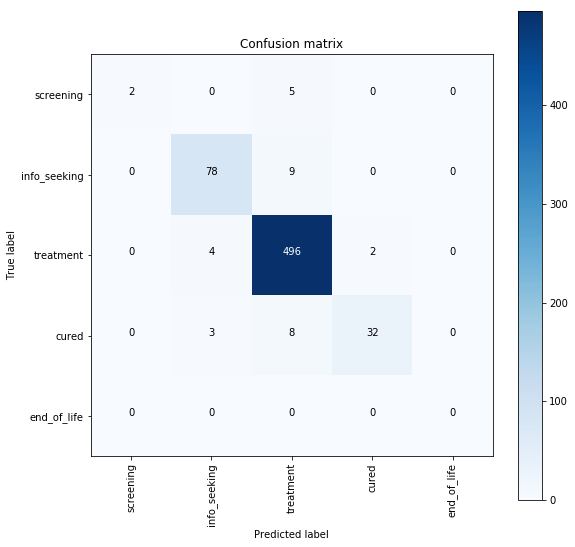

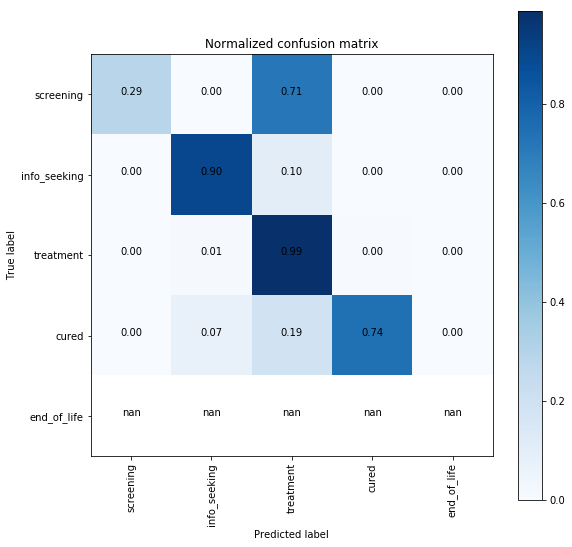

In [33]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# vis code borrowed from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, print_cm=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if print_cm:
        if normalize:
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

fig_size = (9,9)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred, labels=all_phases)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=fig_size)
plot_confusion_matrix(cnf_matrix, classes=all_phases,
                      title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure(figsize=fig_size)
plot_confusion_matrix(cnf_matrix, classes=all_phases, normalize=True,
                      title='Normalized confusion matrix')


plt.show()

/home/srivbane/levon003/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


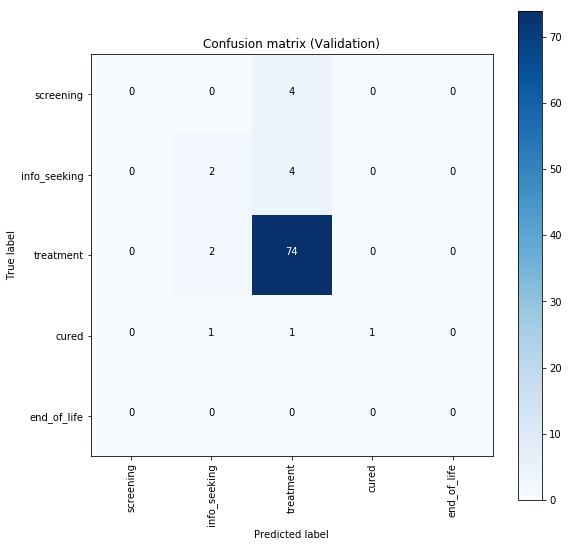

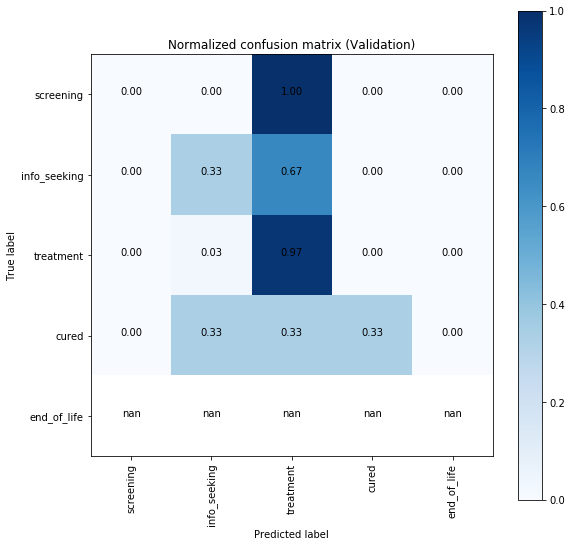

In [34]:
# Compute confusion matrix just on the holdout set
cnf_matrix = confusion_matrix(y_true_valid, y_pred_valid, labels=all_phases)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=fig_size)
plot_confusion_matrix(cnf_matrix, classes=all_phases,
                      title='Confusion matrix (Validation)')

# Plot normalized confusion matrix
plt.figure(figsize=fig_size)
plot_confusion_matrix(cnf_matrix, classes=all_phases, normalize=True,
                      title='Normalized confusion matrix (Validation)')


plt.show()

In [35]:
from sklearn.metrics import classification_report

print("Classification report:")
print(classification_report(y_true, y_pred, labels=all_phases))

Classification report:
              precision    recall  f1-score   support

   screening       1.00      0.29      0.44         7
info_seeking       0.87      0.90      0.88        87
   treatment       0.94      0.99      0.96       502
       cured       0.84      0.74      0.79        43
 end_of_life       0.00      0.00      0.00         0

 avg / total       0.92      0.95      0.93       639



/home/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Uncertainty sampling

### Entropy

In [46]:
# These are the predicted values with the highest entropy
pred_df.sort_values(by="entropy", ascending=False).head(n=20)

,site_id,journal_oid,predicted_phase,screening_prob,info_seeking_prob,treatment_prob,cured_prob,end_of_life_prob,entropy
24,987982,54de01d5ac7ee9c737db1dad,info_seeking,4.09043,1.00061,2.9905,3.62082,5.77143,1.602166
136,987982,54de047e4db921df2809e5f6,info_seeking,4.6252,1.1525,2.80844,2.92306,8.08936,1.602166
342,987982,54dbea22cb16b4013d6474e9,screening,2.12323,3.14492,2.91491,3.41737,14.5376,1.602166
105,987982,54dbebabac7ee96c62e1640f,info_seeking,2.05767,1.02685,1.71577,1.92026,2.24079,1.602166
121,987982,556e642fac7ee98018008042,treatment,10.2007,2.44922,1.03324,3.89947,24.7469,1.602166
487,987982,5518bd84a689b46a3102fadf,treatment,1.10221,1.0965,1.07165,1.09465,1.10278,1.602166
310,987982,54dbeced8b5cd3d83549308a,info_seeking,9.64549,1.14351,2.91209,4.22644,26.0764,1.602166
165,1026937,573bb07ca589b44c08853b9d,treatment,5.25763,3.78418,1.12994,3.70165,8.3489,1.433274
601,1023926,569d8d50ac7ee91e4f798665,treatment,6.48207,2.55964,1.63112,2.49803,13.748,1.424424
525,1023926,55353aaf4db921ab270faa32,treatment,5.07299,2.32467,1.07481,2.43348,8.22049,1.424424
